In [1]:
import os
import sys
import mlflow
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import pandas as pd
import numpy as np
import joblib

# Ensure you have your custom imports available
sys.path.append(os.path.abspath("../features"))
from data_loading import create_features_and_targets
sys.path.append(os.path.abspath("../utils"))
from utils import (
    inverse_scaling,
    log_mlflow_metrics_and_model,
    evaluate_predictions_3_days,
    plot_predictions_vs_true,
)
from feature_rankers import plot_LR_coefficients

In [5]:
particle = "NO2"
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data/processed/combined_data.csv")
data = pd.read_csv(data_path)

X_train, y_train, X_test, y_test, X_val, y_val = create_features_and_targets(data, particle)

Number of rows with missing values dropped: 1011


In [6]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

7.680849109528021
0.352558873742229


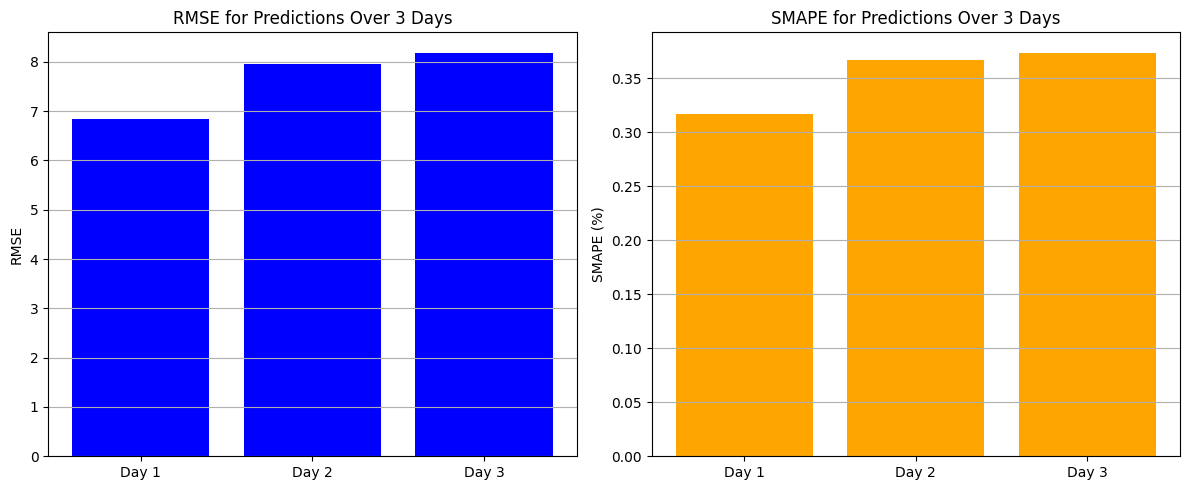

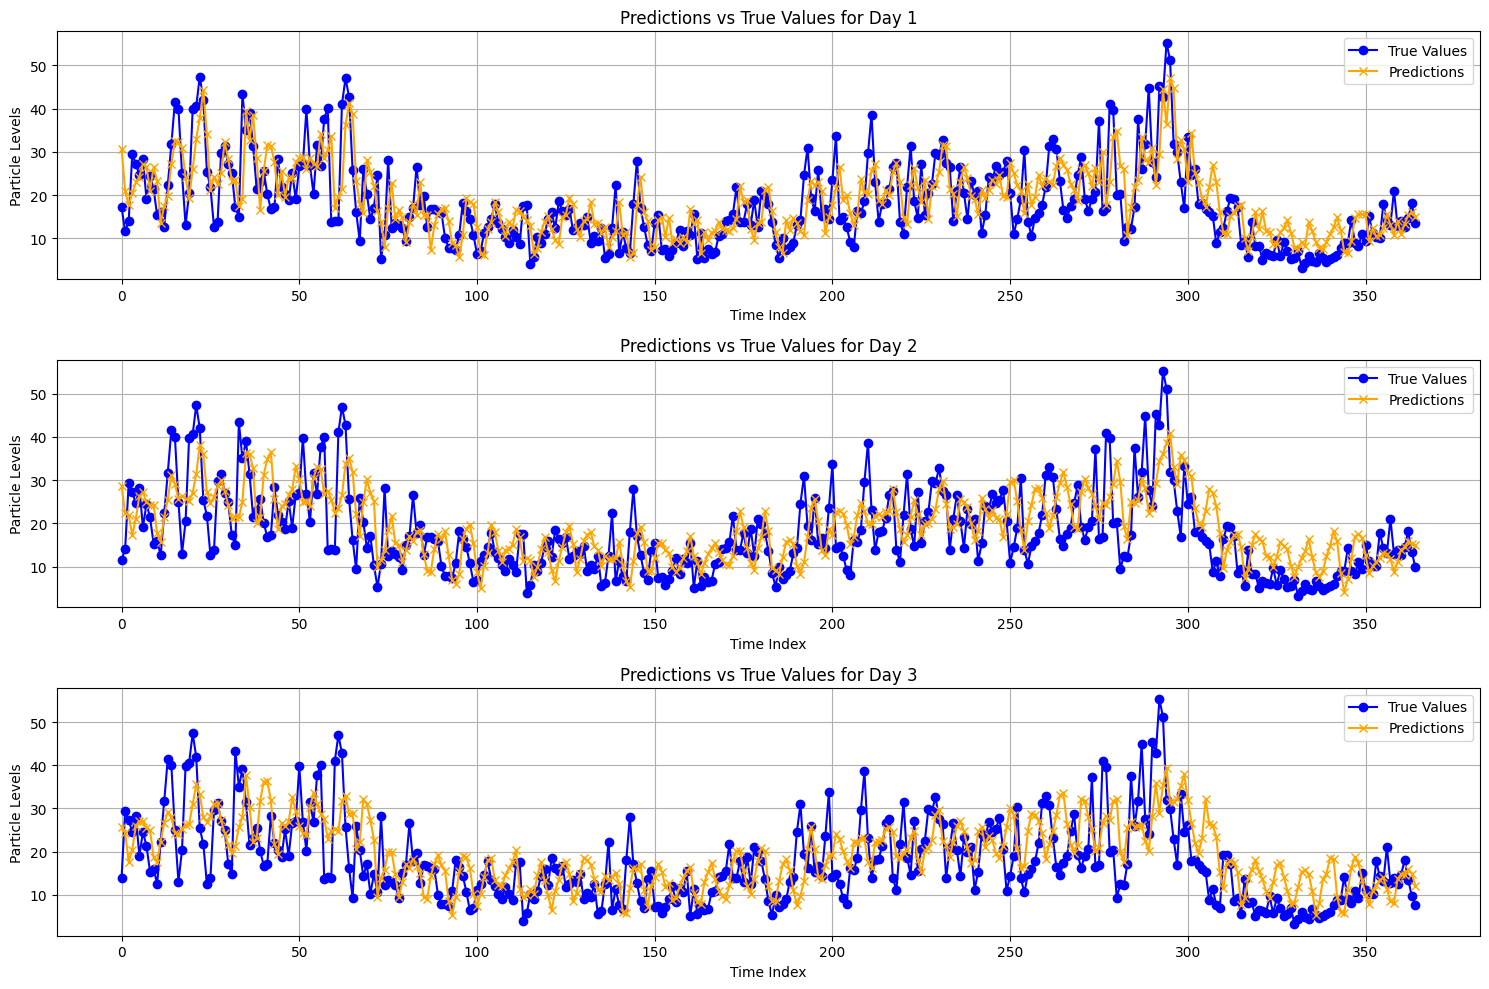

In [7]:
preds = model.predict(X_test)
loaded_scaler = joblib.load(f'target_scaler_{particle}.joblib')
preds = loaded_scaler.inverse_transform(preds)
y_test = loaded_scaler.inverse_transform(y_test)
rmse_values_3day, mape_values_3day, fig_3_days = evaluate_predictions_3_days(
    preds, y_test
)
true_vs_pred_plot = plot_predictions_vs_true(preds, y_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mape = mean_absolute_percentage_error(preds, y_test, symmetric=True)
print(rmse)
print(mape)

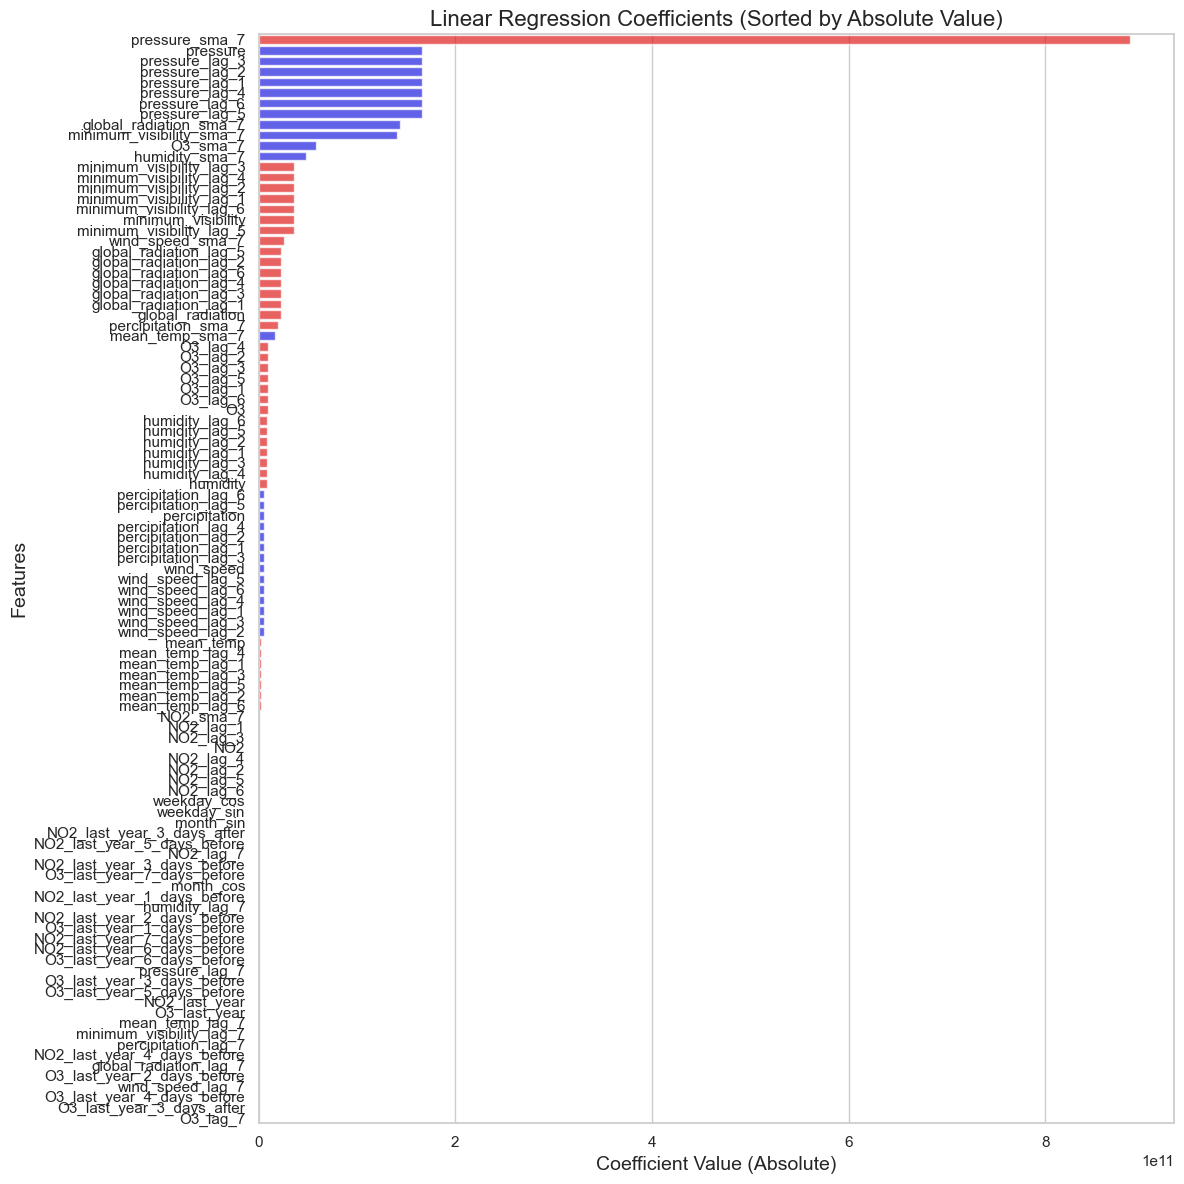

<Figure size 640x480 with 0 Axes>

In [8]:
feature_rank_plot = plot_LR_coefficients(model, X_train)

In [ ]:
model_info = log_mlflow_metrics_and_model(rmse, mape, model, X_train, true_vs_pred_plot, fig_3_days, 
                                          'LR_'+particle, params=None, losses_plot=None, feature_rankings_plot=feature_rank_plot)

In [ ]:
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

loaded_preds = loaded_model.predict(X_test)

print(loaded_preds)